## Import Modules

In [1]:
import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os
from pathlib import Path
from random import randint
from typing import List
import pickle

import torch
from torch import nn
from torch.nn import functional as F

from yolox.data_augment import preproc
from yolox.yolox import YOLOX, get_model, IdentityModule

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

from skorch import NeuralNetClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


import warnings
warnings.filterwarnings('ignore')

## 1. Load the dataset

### I. Baseline Model

In [2]:
# Preparation
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks
path = "dataset/train/"
data = []
for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
data = pd.DataFrame(columns = data) # Empty dataset

In [3]:
# Creating Dataset
target = []
images_arrays = []
count = 0

for subdir, dirs, files in os.walk(path):
    for img in files:
        temp = []
        img = os.path.join(subdir, img)
        img = cv2.imread(img)

        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        blackie = np.zeros(img.shape) # Blank image
        results = pose.process(imgRGB)


        if results.pose_landmarks:
                mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
                landmarks = results.pose_landmarks.landmark

                for i,j in zip(points,landmarks):
                        temp = temp + [j.x, j.y, j.z, j.visibility]
                data.loc[count] = temp
                target.append(subdir.replace(path, ''))
                count +=1


data['target'] = target

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


In [4]:
# Label Encoding for target
labelencoder = LabelEncoder()
data['target'] = labelencoder.fit_transform(data['target'])

In [5]:
# Displaying Dataset
data.head(5)

,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,LEFT_EYE_y,...,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis,target
0,0.385088,0.702528,-0.004816,0.999651,0.364045,0.705285,-0.031445,0.999706,0.361666,0.700772,...,0.525770,0.781881,0.930616,-0.215838,0.980343,0.763475,0.904605,0.165073,0.610637,0
1,0.470336,0.691998,-0.604218,0.982091,0.445842,0.705398,-0.624718,0.987435,0.437711,0.699783,...,0.526152,0.778034,0.569747,0.541724,0.935673,0.764064,0.639336,0.467184,0.604327,0
2,0.453251,0.615995,-0.057232,0.983838,0.440873,0.630020,-0.067001,0.988656,0.440118,0.630212,...,0.552748,0.769751,0.797690,0.004431,0.937697,0.743715,0.761387,0.285678,0.625030,0
3,0.401504,0.383240,-0.309374,0.984927,0.436412,0.378602,-0.318324,0.989338,0.404689,0.379723,...,0.591222,0.622063,0.713210,-0.035523,0.916048,0.569005,0.763766,-0.045453,0.652138,0
4,0.450490,0.683425,-0.067524,0.986200,0.446467,0.690085,-0.090036,0.990196,0.426712,0.690337,...,0.598638,0.656271,0.870245,0.077734,0.911403,0.668724,0.867453,0.307724,0.658130,0


#### Exploratory Data Analysis

In [6]:
label_df = pd.DataFrame()
label_df['label'] = list(map(lambda x: labelencoder.inverse_transform([x])[0], data['target']))

bars = alt.Chart(label_df).mark_bar(size=50).encode(
    x=alt.X('label', axis=alt.Axis(title='Pose')),
    y=alt.Y("count()", axis=alt.Axis(title='Count')),
    tooltip=[alt.Tooltip('count()', title='Count'), 'label'],
    color='label'
)

(bars).interactive().properties(
    height=300, 
    width=700,
    title = "Number of data in each pose",
)


alt.Chart(...)

### II. Yolox Model

In [7]:
# YOLOX Configuration
class dotdict(dict):
    """
    Dotdict is just a dictionary whose elements can be referenced with a dot operation.
    I.e. dotdict['x'] == dotdict.x

    This is useful because the original YOLOX used a custom class to hold a lot of extra configuration that
    we do not need.
    """
    # def __getattr__(self, x):
    #     return self[x]


opt = dotdict()
# All images should be scaled to this input size before passing through YOLOX.
# Any image (of any size) can be scaled using the function `yolox.data_augment.preproc`
# I don't recommend changing this. This is just fine and loads pretty quickly, even on CPU.
opt.input_size = (640, 640)
opt.random_size = (10, 20)  # None; multi-size train: from 448(14*32) to 832(26*32), set None to disable it
opt.test_size = (640, 640)
opt.rgb_means = [0.485, 0.456, 0.406]
opt.std = [0.229, 0.224, 0.225]
opt.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
opt.backbone = "CSPDarknet-nano"
opt.depth_wise = True
opt.use_amp = False  # True, Automatic mixed precision

In [8]:
path = "dataset/train/"
# Creating Dataset
target = []
count = 0

images_arrays = []
target = []

for subdir, dirs, files in os.walk(path):
    for img in files:
        temp = []
        img = os.path.join(subdir, img)
        img = cv2.imread(img)

        img, r = preproc(img, opt.test_size, opt.rgb_means, opt.std)
        images_arrays.append(img)
        target.append(subdir.replace(path, ''))


inp_imgs = np.zeros([len(images_arrays), 3, opt.test_size[0], opt.test_size[1]], dtype=np.float32)
for b_i, image in enumerate(images_arrays):
    inp_imgs[b_i] = image

inp_imgs = torch.from_numpy(inp_imgs).to(opt.device)

Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


In [9]:
# Label Encoding for target
labelencoder = LabelEncoder()
target = labelencoder.fit_transform(target)

# Shuffle them, otherwise our training gets all screwy
inp_imgs, target = shuffle(inp_imgs, target)

print(target)

[2 0 1 ... 2 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


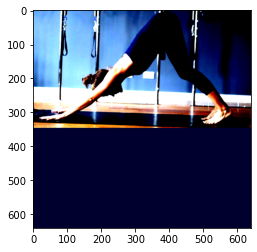

(3, 640, 640)


In [10]:
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

imshow(images_arrays[0])
print(images_arrays[0].shape)

## 2. Define a baseline model and your model

### I. Baseline Model

In [11]:
# Defining baseline model
X,Y = data.iloc[:,:132],data['target']
baseline_model = SVC(kernel = 'poly')

### II. YOLOX Model

In [12]:
# Load YOLOX (Including weights pretrained on COCO)

# The head (i.e. the connection between the YOLOX backbone and neck to the rest of the model) is by default just an IdentityModule.
# This head should be exchanged with some torch module that performs the rest of the function (in this case classification)
# The head module should be a torch module expecting an input that is a list of 3 tensors of sizes:
#        [torch.Size([BATCH_SIZE, 64, 80, 80]), torch.Size([BATCH_SIZE, 128, 40, 40]), torch.Size([BATCH_SIZE, 256, 20, 20])]
# Note: These sizes may change if the `opt.input_size` or `opt.test_size` are changed.
# Each of these inputs is a different output of the YOLOX neck and represents the features learned at various scales.

# The YOLOX model expects a single tensor input of size: [BATCH_SIZE, 3, opt.test_size[0], opt.test_size[1]]
# BATCHSIZE is the Batch size
# 3 is the number of color channels (the YOLOX is pretrained on 3 channels. Even if the image is grayscale, convert it to RGB
# opt.test_size[0] is the number of horizontal pixels in the input
# opt.test_size[1] is the number of vertical pixels in the input

class ClassificationHead(nn.Module):
    def __init__(self, input_sizes:List[int], input_channels:List[int], num_classes:int, hidden_features:int = 128):
        super(ClassificationHead, self).__init__()
        self.fc0a = nn.Linear(input_channels[0]*input_sizes[0]**2,hidden_features)
        self.fc0b = nn.Linear(input_channels[1]*input_sizes[1]**2,hidden_features)
        self.fc0c = nn.Linear(input_channels[2]*input_sizes[2]**2,hidden_features)
        # Concatenate the three outputs into one linear layer
        self.fc1 = nn.Linear(len(input_sizes) * hidden_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_classes)

    def forward(self,x):
        a = F.relu(self.fc0a(torch.flatten(x[0],1)))
        b = F.relu(self.fc0b(torch.flatten(x[1],1)))
        c = F.relu(self.fc0c(torch.flatten(x[2],1)))
        x = torch.cat([a,b,c], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.softmax(self.fc3(x), dim=1)
        x = self.fc3(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eps = 1e-3
                m.momentum = 0.03


model = get_model(opt,
                  # head=IdentityModule(),
                  head=ClassificationHead([80,40,20], [64,128,256], 5),
                  freeze_layers=True)

# Check if frozen
assert not any(p.requires_grad for p in model.backbone.parameters())

==>> loaded pretrained_models/yolox-nano.pth, epoch 294
--> Drop parameter head.stems.0.conv.weight.
--> Drop parameter head.stems.0.bn.weight.
--> Drop parameter head.stems.0.bn.bias.
--> Drop parameter head.stems.0.bn.running_mean.
--> Drop parameter head.stems.0.bn.running_var.
--> Drop parameter head.stems.0.bn.num_batches_tracked.
--> Drop parameter head.stems.1.conv.weight.
--> Drop parameter head.stems.1.bn.weight.
--> Drop parameter head.stems.1.bn.bias.
--> Drop parameter head.stems.1.bn.running_mean.
--> Drop parameter head.stems.1.bn.running_var.
--> Drop parameter head.stems.1.bn.num_batches_tracked.
--> Drop parameter head.stems.2.conv.weight.
--> Drop parameter head.stems.2.bn.weight.
--> Drop parameter head.stems.2.bn.bias.
--> Drop parameter head.stems.2.bn.running_mean.
--> Drop parameter head.stems.2.bn.running_var.
--> Drop parameter head.stems.2.bn.num_batches_tracked.
--> Drop parameter head.cls_convs.0.0.dconv.conv.weight.
--> Drop parameter head.cls_convs.0.0.dco

## 3. Run a training loop on a training set with both models

### I. Baseline Model

In [13]:
baseline_model.fit(X,Y)

SVC(kernel='poly')

### II. YOLOX Model

In [14]:
# Run inference as a test to make sure network runs (i.e. all tensors are the right shape)
# Use only the first 10 images, for speed's sake
with torch.no_grad():
    yolo_outputs = model(inp_imgs[:10])
    # print(yolo_outputs)
    print(yolo_outputs.shape)

torch.Size([10, 5])


In [15]:
''' Uncomment this for tuning hyperparameter and saving the best model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Hyper parameter tuning with cross validation
net = NeuralNetClassifier(
    model,
    max_epochs=15,
    lr=0.001,
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device=device,
    optimizer=torch.optim.Adam
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False,
               # verbose=0
               )
# net.fit(inp_imgs[:20], torch.as_tensor(target[:20]))  # Make sure the model works on a small set of data
params = {
    'lr': [0.001, 0.0001, 0.00001]
}
# params = {
#     'optimizer': [torch.optim.SGD, torch.optim.Adam]
# }
gs = GridSearchCV(net, params,
                  # refit=False,
                  cv=3,
                  scoring='neg_log_loss',
                  verbose=3, error_score='raise')

gs.fit(inp_imgs, torch.as_tensor(target))
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

# Save best model to pickel file
with open('yolox.pkl', 'wb') as f:
    pickle.dump(gs, f)
    
    
'''

' Uncomment this for tuning hyperparameter and saving the best model\n\ndevice = \'cuda\' if torch.cuda.is_available() else \'cpu\'\n# Hyper parameter tuning with cross validation\nnet = NeuralNetClassifier(\n    model,\n    max_epochs=15,\n    lr=0.001,\n    criterion=nn.CrossEntropyLoss(),\n    # Shuffle training data on each epoch\n    iterator_train__shuffle=True,\n    device=device,\n    optimizer=torch.optim.Adam\n)\n\n# deactivate skorch-internal train-valid split and verbose logging\nnet.set_params(train_split=False,\n               # verbose=0\n               )\n# net.fit(inp_imgs[:20], torch.as_tensor(target[:20]))  # Make sure the model works on a small set of data\nparams = {\n    \'lr\': [0.001, 0.0001, 0.00001]\n}\n# params = {\n#     \'optimizer\': [torch.optim.SGD, torch.optim.Adam]\n# }\ngs = GridSearchCV(net, params,\n                  # refit=False,\n                  cv=3,\n                  scoring=\'neg_log_loss\',\n                  verbose=3, error_score=\'raise

In [16]:
# Load model from pickel file
with open('yolox.pkl', 'rb') as f:
    model = pickle.load(f)

In [17]:
model.best_params_

{'lr': 0.0001}

In [18]:
model.predict(inp_imgs[:20]), target[:20]

(array([2, 0, 1, 3, 4, 2, 4, 1, 4, 0, 3, 1, 1, 4, 4, 2, 3, 0, 3, 2]),
 array([2, 0, 1, 3, 4, 2, 4, 1, 4, 0, 3, 1, 1, 4, 4, 2, 3, 0, 3, 2]))

## 4. Evaluate both models on a withheld test set

### I. Baseline Model

In [20]:
# Predicting test 
test_path = "dataset/test/"
y_pred = []
y_test = []
for subdir, dirs, files in os.walk(path):
    for img in files:
        temp = []
        img = os.path.join(subdir, img)
        img = cv2.imread(img)

        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        blackie = np.zeros(img.shape) # Blank image
        results = pose.process(imgRGB)

        if results.pose_landmarks:
                mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
                landmarks = results.pose_landmarks.landmark

                for i,j in zip(points,landmarks):
                        temp = temp + [j.x, j.y, j.z, j.visibility]
                y_pred.append(baseline_model.predict([temp]))
                y_test.append(labelencoder.transform([subdir.replace(path, '')])[0])

Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


In [21]:
# Evaluating the baseline model (SVM)
baseline_report = classification_report(y_test, y_pred, target_names=labelencoder.classes_)

### II. YOLOX Model

In [22]:
path = "dataset/test/"

# Creating Dataset
y_test = []
images_arrays = []

for subdir, dirs, files in os.walk(path):
    for img in files:
        temp = []
        img = os.path.join(subdir, img)
        img = cv2.imread(img)

        img, r = preproc(img, opt.test_size, opt.rgb_means, opt.std)
        images_arrays.append(img)
        y_test.append(subdir.replace(path, ''))


test_imgs = np.zeros([len(images_arrays), 3, opt.test_size[0], opt.test_size[1]], dtype=np.float32)
for b_i, image in enumerate(images_arrays):
    test_imgs[b_i] = image

test_imgs = torch.from_numpy(test_imgs).to(opt.device)
y_test = labelencoder.fit_transform(y_test)

# Predictions
y_pred = model.predict(test_imgs)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [23]:
# Evaluating the YOLOX model
yolox_report = classification_report(y_test, y_pred, target_names=labelencoder.classes_)

## 5. Display results on the test set for both models

### I. Baseline Model

In [24]:
print(baseline_report)

              precision    recall  f1-score   support

     downdog       0.99      0.97      0.98       196
     goddess       0.93      0.84      0.88       164
       plank       0.94      0.98      0.96       225
        tree       0.97      0.85      0.91       136
    warrior2       0.86      0.96      0.91       238

    accuracy                           0.93       959
   macro avg       0.94      0.92      0.93       959
weighted avg       0.93      0.93      0.93       959



### II. YOLOX Model

In [25]:
print(yolox_report)

              precision    recall  f1-score   support

     downdog       0.91      0.87      0.89        97
     goddess       0.76      0.84      0.80        80
       plank       0.89      0.85      0.87       115
        tree       0.86      0.96      0.90        69
    warrior2       0.90      0.85      0.88       109

    accuracy                           0.87       470
   macro avg       0.87      0.87      0.87       470
weighted avg       0.87      0.87      0.87       470

